In [5]:
import wandb
import dataclasses
import utils
import run_registry

api = wandb.Api()

@dataclasses.dataclass
class Plot:
    title: str
    plt_scatter_kwargs: list[dict] = dataclasses.field(default_factory=list)

probe_results = {}
for model_name, run_id in run_registry.RUNS.items():
    run = api.run(f"ananthag/Head Word Final 2/{run_id}")
    num_layers = run.config["num_layers"]
    layer_accs = []
    for layer in range(num_layers):
        layer_accs.append(run.summary_metrics[f"layer_{layer}/test/acc"])
    probe_results[model_name] = max(layer_accs)
    
#     df = run.history()
#     num_layers = utils.get_num_layers(AutoConfig.from_pretrained(model_name))
#     values = []
#     for layer in range(num_layers):
#         values.append(df[f"layer_{layer}/val/acc"].dropna().max())
#     plt_scatter_kwargs.append(dict(
#         x=range(num_layers),
#         y=values,
#         label=model_name,
#     ))

# def get_plot(model_family):
#     plot = Plot(model_family)
#     for model, run_id in model_families[model_family]:
#         run = api.run(f"ananthag/Head Word New Sweeps/{run_id}")
#         df = run.history()
#         num_layers = utils.get_num_layers(AutoConfig.from_pretrained(model))
#         values = []
#         for layer in range(num_layers):
#             values.append(df[f"layer_{layer}/val/acc"].dropna().max())
#         plot.plt_scatter_kwargs.append(dict(
#             x=range(num_layers),
#             y=values,
#             label=model,
#         ))
#     return plot

In [6]:
probe_results

{'EleutherAI/pythia-70m': 0.5961056519158477,
 'EleutherAI/pythia-160m': 0.6417430587614588,
 'EleutherAI/pythia-410m': 0.6567466860120029,
 'EleutherAI/pythia-1.4b': 0.6855833278374992,
 'EleutherAI/pythia-2.8b': 0.7005210050781507,
 'tiiuae/falcon-7b': 0.677141726571259,
 'gpt2-large': 0.7318802347820352,
 'gpt2-medium': 0.7060278309041746,
 'gpt2': 0.6998285299742795,
 'EleutherAI/gpt-j-6b': 0.7141561696234254,
 'meta-llama/Llama-2-7b-hf': 0.7595627514344128,
 'gpt2-xl': 0.7275934841390226,
 'mistralai/Mistral-7B-v0.1': 0.7704280155642024,
 'google/gemma-2b': 0.6349831827474774,
 'microsoft/phi-2': 0.737502473125371}

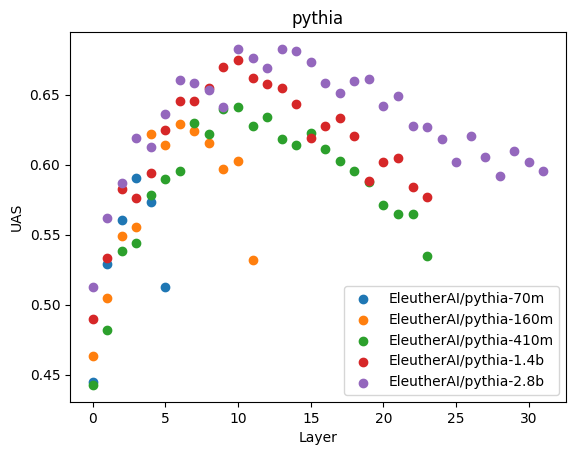

In [19]:
import matplotlib.pyplot as plt

for kwargs in plot.plt_scatter_kwargs:
    plt.scatter(**kwargs)
plt.xlabel('Layer')
plt.ylabel('UAS')
plt.title(plot.title)
plt.legend()
plt.show()



In [57]:
import json
import numpy as np

all_scatter_kwargs = []
all_annotations = []

family = {
    'gpt2': 'red',
    'pythia': 'green',
}

plot_names = {
    'gpt2': 'GPT-2',
    'gpt2-medium': 'GPT-2 Medium',
    'gpt2-large': 'GPT-2 Large',
    'gpt2-xl': 'GPT-2 XL',
    'EleutherAI/pythia-70m': 'Pythia 70M',
    'EleutherAI/pythia-160m': 'Pythia 160M',
    'EleutherAI/pythia-410m': 'Pythia 410M',
    'EleutherAI/pythia-1.4b': 'Pythia 1.4B',
    'EleutherAI/pythia-2.8b': 'Pythia 2.8B',
    "microsoft/phi-2": "Phi-2",
    "google/gemma-2b": "Gemma 2B",
    "mistralai/Mistral-7B-v0.1": "Mistral 7B",
    "meta-llama/Llama-2-7b-hf": "Llama 7B",
    "EleutherAI/gpt-j-6b": "GPT-J 6B",
    "tiiuae/falcon-7b": "Falcon 7B"
}

sg_num_items = {'fgd_hierarchy.json': 24,
 'subordination_src-src.json': 23,
 'reflexive_src_fem.json': 19,
 'npz_obj_mod.json': 24,
 'npi_src_any.json': 38,
 'reflexive_prep_fem.json': 19,
 'fgd-embed3.json': 21,
 'subordination.json': 23,
 'reflexive_prep_masc.json': 19,
 'cleft_modifier.json': 40,
 'fgd_subject.json': 24,
 'mvrr.json': 28,
 'npi_src_ever.json': 38,
 'npz_ambig.json': 24,
 'cleft.json': 40,
 'npi_orc_ever.json': 38,
 'mvrr_mod.json': 28,
 'nn-nv-rpl.json': 1,
 'center_embed.json': 28,
 'fgd-embed4.json': 21,
 'reflexive_src_masc.json': 19,
 'subordination_pp-pp.json': 23,
 'subordination_orc-orc.json': 23,
 'number_orc.json': 19,
 'npz_obj.json': 24,
 'reflexive_orc_masc.json': 19,
 'number_prep.json': 19,
 'fgd_object.json': 24,
 'npz_ambig_mod.json': 24,
 'center_embed_mod.json': 28,
 'number_src.json': 19,
 'reflexive_orc_fem.json': 19,
 'fgd_pp.json': 24,
 'npi_orc_any.json': 38}

for model_name, probe_value in probe_results.items():
    with open(f'surprisals/{model_name.replace("/", "-")}.json') as f:
        surprisal_results = json.load(f)
        vals = []
        weights = []
        for file_name, value in surprisal_results.items():
            vals.append(value)
            weights.append(sg_num_items[file_name])
        x = np.average(vals, weights=weights)
        if 'gemma' in model_name:
            print('prev', np.mean(vals), 'new', x)
    kwargs = {}
    label = None
    if 'gpt2' in model_name:
        kwargs['color'] = 'red'
    elif 'pythia' in model_name:
        kwargs['color'] = 'green'
    kwargs |= dict(
        x=x,
        y=probe_value,
        s=80
    )
    xytext = (0, 10)
    if model_name == 'gpt2-xl':
        xytext=(30, -3)
    if model_name == 'gpt2-large':
        xytext=(-40, -3)
    if model_name == 'gpt2':
        xytext=(-20, -3)
    annotation = dict(
        text=plot_names[model_name],
        xy=(kwargs['x'], kwargs['y']),
        textcoords="offset points",
        xytext=xytext, ha='center'
    )
    all_annotations.append(annotation)

    
    all_scatter_kwargs.append(kwargs)

prev 0.7813331282169618 new 0.836104513064133


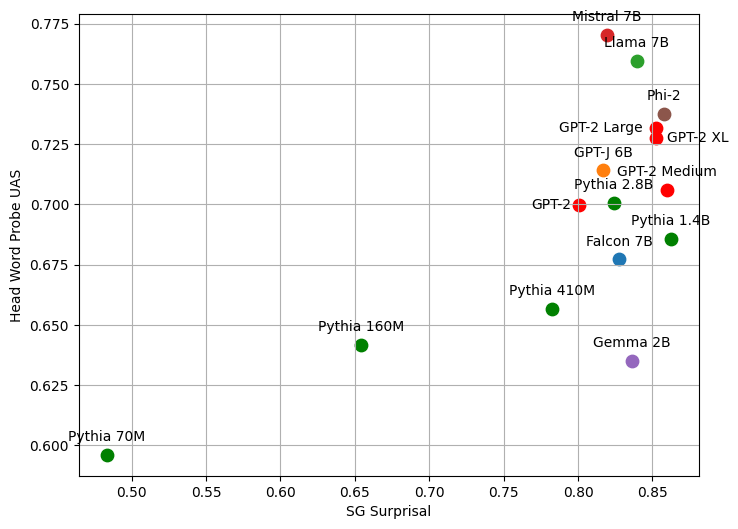

In [59]:
import matplotlib.pyplot as plt

# Create the scatter plot
plt.figure(figsize=(8, 6))  # Set the figure size

for kwargs, annotations in zip(all_scatter_kwargs, all_annotations):
    plt.scatter(**kwargs)
    plt.annotate(**annotations)

plt.xlabel('SG Surprisal')
plt.ylabel('Head Word Probe UAS')

# Add legend
# plt.legend()


# Show the plot
plt.grid(True)
plt.savefig('final_plots/weighted_average.png')
# plt.show()

In [65]:
sg_mapping = {
    "fgd_hierarchy.json": "Long-Distance Dependencies",
    "subordination_src-src.json": "Gross Syntactic State",
    "reflexive_src_fem.json": "Licensing",
    "npz_obj_mod.json": "Garden-Path Effects",
    "npi_src_any.json": "Licensing",
    "reflexive_prep_fem.json": "Licensing",
    "fgd-embed3.json": "Long-Distance Dependencies",
    "subordination.json": "Gross Syntactic State",
    "reflexive_prep_masc.json": "Licensing",
    "cleft_modifier.json": "Long-Distance Dependencies",
    "fgd_subject.json": "Long-Distance Dependencies",
    "mvrr.json": "Garden-Path Effects",
    "npi_src_ever.json": "Licensing",
    "npz_ambig.json": "Garden-Path Effects",
    "cleft.json": "Long-Distance Dependencies",
    "npi_orc_ever.json": "Licensing",
    "mvrr_mod.json": "Garden-Path Effects",
    "center_embed.json": "Center Embedding",
    "fgd-embed4.json": "Long-Distance Dependencies",
    "reflexive_src_masc.json": "Licensing",
    "subordination_pp-pp.json": "Gross Syntactic State",
    "subordination_orc-orc.json": "Gross Syntactic State",
    "number_orc.json": "Agreement",
    "npz_obj.json": "Garden-Path Effects",
    "reflexive_orc_masc.json": "Licensing",
    "number_prep.json": "Agreement",
    "fgd_object.json": "Long-Distance Dependencies",
    "npz_ambig_mod.json": "Garden-Path Effects",
    "center_embed_mod.json": "Center Embedding",
    "number_src.json": "Agreement",
    "reflexive_orc_fem.json": "Licensing",
    "fgd_pp.json": "Long-Distance Dependencies",
    "npi_orc_any.json": "Licensing",
}

def get_kwargs_for_test_suite(test_suite):
    all_annotations = []
    all_scatter_kwargs = []
    for model_name, probe_value in probe_results.items():
        with open(f'surprisals/{model_name.replace("/", "-")}.json') as f:
            surprisal_results = json.load(f)
            vals = []
            weights = []
            for file_name, value in surprisal_results.items():
                if 'nn-nv-rpl' in file_name:
                    continue
                if sg_mapping[file_name] == test_suite:
                    vals.append(value)
                    weights.append(sg_num_items[file_name])
            x = np.average(vals, weights=weights)

        kwargs = {}
        if 'gpt2' in model_name:
            kwargs['color'] = 'red'
        elif 'pythia' in model_name:
            kwargs['color'] = 'green'
        kwargs |= dict(
            x=x,
            y=probe_value,
            s=80
        )
        xytext = (0, 10)
        if model_name == 'gpt2-xl':
            xytext=(30, -3)
        if model_name == 'gpt2-large':
            xytext=(-40, -3)
        if model_name == 'gpt2':
            xytext=(-20, -3)
        annotation = dict(
            text=plot_names[model_name],
            xy=(kwargs['x'], kwargs['y']),
            textcoords="offset points",
            xytext=xytext, ha='center'
        )
        all_annotations.append(annotation)

        
        all_scatter_kwargs.append(kwargs)
    return all_scatter_kwargs, all_annotations

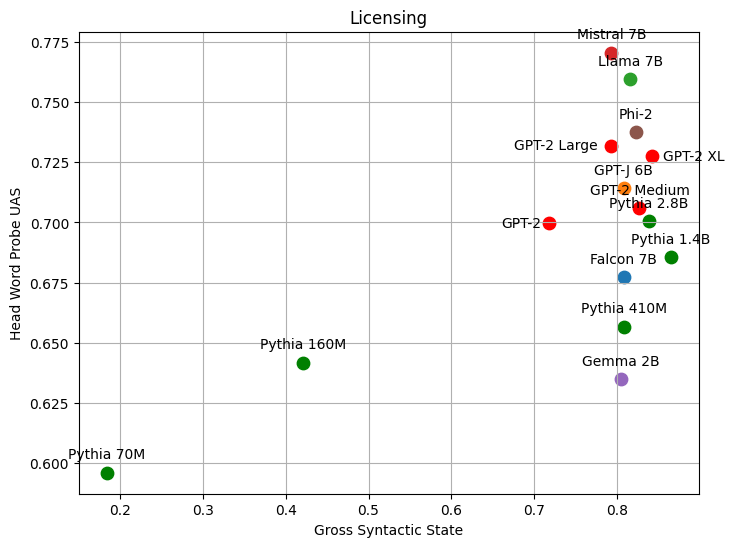

In [72]:
test_suite = "Licensing"
all_scatter_kwargs, all_annotations = get_kwargs_for_test_suite(test_suite)
plt.figure(figsize=(8, 6))  # Set the figure size

for kwargs, annotations in zip(all_scatter_kwargs, all_annotations):
    plt.scatter(**kwargs)
    plt.annotate(**annotations)

plt.xlabel('Gross Syntactic State')
plt.ylabel('Head Word Probe UAS')

# Show the plot
plt.grid(True)
plt.title(test_suite)
plt.savefig(f'final_plots/{test_suite.replace(' ', '_').lower()}.png')

In [33]:
with open('llama_surprisal.json', 'r') as f:
    llama_surprisal_results = json.load(f)
llama_surprisal_results = [np.mean(list(task_surprisal.values())) for k, task_surprisal in llama_surprisal_results.items()]

with open('EleutherAI_pythia_surprisal.json', 'r') as f:
    pythia_surprisal_results = json.load(f)
pythia_surprisal_results = [np.mean(list(task_surprisal.values())) for k, task_surprisal in pythia_surprisal_results.items()]


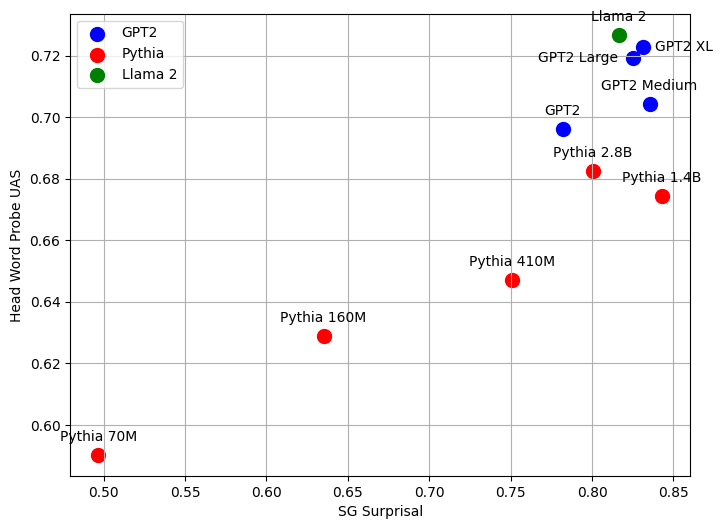

In [54]:
import matplotlib.pyplot as plt

# Create the scatter plot
plt.figure(figsize=(8, 6))  # Set the figure size

# Plot the first set of points in blue
plt.scatter(gpt_surprisal_results, gpt_probe_results, color='blue', label='GPT2', s=100)  # Set marker size to 100
gpt_labels = ['GPT2', 'GPT2 Medium', 'GPT2 Large', 'GPT2 XL']

# Plot the second set of points in red
plt.scatter(pythia_surprisal_results, pythia_probe_results, color='red', label='Pythia', s=100)
pythia_labels = ['Pythia 70M', 'Pythia 160M', 'Pythia 410M', 'Pythia 1.4B', 'Pythia 2.8B']

plt.scatter(llama_surprisal_results, llama_probe_results, color='green', label='Llama 2', s=100)
llama_labls = ['Llama 2']

# Add labels to each data point
for i, txt in enumerate(gpt_labels):
    plt.annotate(txt, (gpt_surprisal_results[i], gpt_probe_results[i]), textcoords="offset points", xytext=(0, 10), ha='center')
    if i == 1:
        break

plt.annotate('GPT2 Large', (gpt_surprisal_results[2], gpt_probe_results[2]), textcoords="offset points", xytext=(-40, -3), ha='center')
plt.annotate('GPT2 XL', (gpt_surprisal_results[3], gpt_probe_results[3]), textcoords="offset points", xytext=(30, -3), ha='center')


for i, txt in enumerate(pythia_labels):
    plt.annotate(txt, (pythia_surprisal_results[i], pythia_probe_results[i]), textcoords="offset points", xytext=(0, 10), ha='center')

for i, txt in enumerate(llama_labls):
    plt.annotate(txt, (llama_surprisal_results[i], llama_probe_results[i]), textcoords="offset points", xytext=(0, 10), ha='center')
# Add labels and title
plt.xlabel('SG Surprisal')
plt.ylabel('Head Word Probe UAS')

# Add legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [16]:
with open('surprisals/meta-llama-Llama-2-7b-hf.json'):
    llama_surprisal_results = json.load(f)


NameError: name 'json' is not defined

In [17]:
gpt_surprisal_results

NameError: name 'gpt_surprisal_results' is not defined

In [13]:
import os

out = {}
for file_name in os.listdir('sg_test_suites'):
    if 'fgd' in file_name or 'cleft' in file_name:
        out[file_name] = 'Long-Distance Dependencies'
    elif 'subordination' in file_name:
        out[file_name] = 'Gross Syntactic State'
    elif 'center_embed' in file_name:
        out[file_name] = 'Center Embedding'
    elif 'reflexive' in file_name or 'npi_' in file_name:
        out[file_name] = 'Licensing'
    elif 'mvrr' in file_name or 'npz' in file_name:
        out[file_name] = 'Garden-Path Effects'
    elif 'number' in file_name:
        out[file_name] = 'Agreement'
    else:
        print(file_name)

nn-nv-rpl.json


In [14]:
out

{'fgd_hierarchy.json': 'Long-Distance Dependencies',
 'subordination_src-src.json': 'Gross Syntactic State',
 'reflexive_src_fem.json': 'Licensing',
 'npz_obj_mod.json': 'Garden-Path Effects',
 'npi_src_any.json': 'Licensing',
 'reflexive_prep_fem.json': 'Licensing',
 'fgd-embed3.json': 'Long-Distance Dependencies',
 'subordination.json': 'Gross Syntactic State',
 'reflexive_prep_masc.json': 'Licensing',
 'cleft_modifier.json': 'Long-Distance Dependencies',
 'fgd_subject.json': 'Long-Distance Dependencies',
 'mvrr.json': 'Garden-Path Effects',
 'npi_src_ever.json': 'Licensing',
 'npz_ambig.json': 'Garden-Path Effects',
 'cleft.json': 'Long-Distance Dependencies',
 'npi_orc_ever.json': 'Licensing',
 'mvrr_mod.json': 'Garden-Path Effects',
 'center_embed.json': 'Center Embedding',
 'fgd-embed4.json': 'Long-Distance Dependencies',
 'reflexive_src_masc.json': 'Licensing',
 'subordination_pp-pp.json': 'Gross Syntactic State',
 'subordination_orc-orc.json': 'Gross Syntactic State',
 'number_

In [49]:
weights = {}
for file_name in os.listdir('sg_test_suites'):
    with open(f'sg_test_suites/{file_name}', 'r') as f:
        data = json.load(f)
        weights[file_name] = len(data['items'])

In [50]:
weights

{'fgd_hierarchy.json': 24,
 'subordination_src-src.json': 23,
 'reflexive_src_fem.json': 19,
 'npz_obj_mod.json': 24,
 'npi_src_any.json': 38,
 'reflexive_prep_fem.json': 19,
 'fgd-embed3.json': 21,
 'subordination.json': 23,
 'reflexive_prep_masc.json': 19,
 'cleft_modifier.json': 40,
 'fgd_subject.json': 24,
 'mvrr.json': 28,
 'npi_src_ever.json': 38,
 'npz_ambig.json': 24,
 'cleft.json': 40,
 'npi_orc_ever.json': 38,
 'mvrr_mod.json': 28,
 'nn-nv-rpl.json': 1,
 'center_embed.json': 28,
 'fgd-embed4.json': 21,
 'reflexive_src_masc.json': 19,
 'subordination_pp-pp.json': 23,
 'subordination_orc-orc.json': 23,
 'number_orc.json': 19,
 'npz_obj.json': 24,
 'reflexive_orc_masc.json': 19,
 'number_prep.json': 19,
 'fgd_object.json': 24,
 'npz_ambig_mod.json': 24,
 'center_embed_mod.json': 28,
 'number_src.json': 19,
 'reflexive_orc_fem.json': 19,
 'fgd_pp.json': 24,
 'npi_orc_any.json': 38}